In [267]:
import dlib
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import dlib
import cv2
import json
import numpy as np
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [268]:
#이미지 불러오기 && 랜드마크 추출
def readImage(imageName) :
    #read image
    image = cv2.imread(imageName) # read 3024x4032 image -> IPhone xr 카메라 규격
    image = cv2.resize(image,(300,400)) # resize image to 300x400
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #extract landmark
    face = detector(image, 1)[0]
    landmarks = predictor(image, face)
    points = landmarks.parts()
    return image, points

In [269]:
#회전해야할 각도 계산
def calAngle(points) :
    midx = points[39].x + points[42].x
    midy = points[39].y + points[42].y
    angle = math.atan((midx - points[33].x) / (points[33].y - midy))
    return angle

In [270]:
#origin 점을 기준으로 angle각도 만큼 좌표회전
def rotate(origin, point, angle):
    angle = angle * -1
    ox, oy = origin
    px, py = point
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [271]:
#이미지 및 랜드마크 회전
def rotateImage(image, points, angle) :
    #이미지 회전
    h,w = image.shape[:2]
    rotatedImage = np.copy(image)
    m1 = cv2.getRotationMatrix2D((w/2,h/2), angle,1)
    rotatedImage = cv2.warpAffine(image,m1,(w,h))
    
    #랜드마크 회전
    for p in points :
        p.x, p.y = list(map(int, rotate((w/2,h/2),(p.x,p.y),math.radians(angle))))
    return rotatedImage, points

In [272]:
#이미지 자르기 && 랜드마크도 이동시켜줌
def cutImage(image, points) : 
    ##########중간점 찾기##########
    x_min = 10000
    x_max = 0
    y_min = 10000
    y_max = 0
    for i, p in enumerate(points) :
        if(x_min > p.x) :
            x_min = p.x
        if(x_max < p.x) :
            x_max = p.x
        if(y_min > p.y) :
            y_min = p.y
        if(y_max < p.y) :
            y_max = p.y
    xmid = math.ceil((x_max + x_min) / 2)
    ymid = math.ceil((y_max + y_min) / 2)
    
    ##############자르기#############
    image = image[ymid-64:ymid+63,xmid-64:xmid+63]
    
    ##########바뀐 사진에 맞게 랜드마크 이동##########
    h,w = image.shape[:2]
    for p in points :
        p.x = p.x - xmid + 64
        p.y = p.y - ymid + 64

    return image, points

In [273]:
#이미지 출력
def printImage(image, points) :
    for p in points :
        cv2.circle(image, (p.x, p.y), 2, (0, 255, 0), -1)
    plt.imshow(image, cmap='gray')

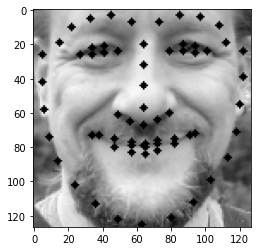

In [274]:
image, points = readImage("xr.jpg") #이미지 읽어 오기
angle = calAngle(points) # 회전해야할 각도 계산
image, points = rotateImage(image,points, angle) #이미지 회전
image, points = cutImage(image, points) #이미지 자르기
printImage(image, points) #이미지 출력